# Inputs & imports : that's all you need to give !

In [1]:
!pip install mlbox

In [2]:
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

In [4]:
paths = ["/content/train.csv","/content/test.csv"]
target_name = "Survived"

# Now let MLBox do the job ! 

## ... to read and clean all the files 

In [5]:
rd = Reader(sep = ",")
df = rd.train_test_split(paths, target_name)   #reading and preprocessing (dates, ...)


reading csv : train.csv ...
cleaning data ...
CPU time: 3.6308062076568604 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.05842089653015137 seconds

> Number of common features : 11

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 5
> Number of numerical features: 6
> Number of training samples : 891
> Number of test samples : 418

> Top sparse features (% missing values on train set):
Cabin       77.1
Age         19.9
Embarked     0.2
dtype: float64

> Task : classification
0.0    549
1.0    342
Name: Survived, dtype: int64

encoding target ...


In [6]:
dft = Drift_thresholder()
df = dft.fit_transform(df)   #removing non-stable features (like ID,...)


computing drifts ...
CPU time: 0.18790340423583984 seconds

> Top 10 drifts

('PassengerId', 1.0)
('Name', 0.9918391604868151)
('Ticket', 0.6832937401745363)
('Cabin', 0.1840952424805744)
('Embarked', 0.07666917468876133)
('SibSp', 0.0647662392421644)
('Age', 0.02793052256460493)
('Pclass', 0.027211613821813252)
('Parch', 0.02598187136377983)
('Fare', 0.025330054823707426)

> Deleted variables : ['Name', 'PassengerId', 'Ticket']
> Drift coefficients dumped into directory : save


## ... to tune all the hyper-parameters

In [7]:
opt = Optimiser(scoring = "accuracy", n_folds = 5)

/usr/local/lib/python3.7/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


**LightGBM**

In [15]:
space = {
    
        'est__strategy':{"search":"choice",
                                  "space":["LightGBM"]},    
        'est__n_estimators':{"search":"choice",
                                  "space":[150]},    
        'est__colsample_bytree':{"search":"uniform",
                                  "space":[0.8,0.95]},
        'est__subsample':{"search":"uniform",
                                  "space":[0.8,0.95]},
        'est__max_depth':{"search":"choice",
                                  "space":[4,5,6,7,8]},
        'est__learning_rate':{"search":"choice",
                                  "space":[0.09]} 
    
        }

params = opt.optimise(space, df,75)

##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.8664007863514916, 'learning_rate': 0.09, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.8487205918323664, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : accuracy = 0.8204632477559475
VARIANCE : 0.030095644339076764 (fold 1 = 0.7877094972067039, fold 2 = 0.8539325842696629, fold 3 = 0.8033707865168539, fold 4 = 0.797752808988764, fold 5 = 0.859550561

But you can also tune the whole Pipeline ! Indeed, you can choose:

* different strategies to impute missing values
* different strategies to encode categorical features (entity embeddings, ...)
* different strategies and thresholds to select relevant features (random forest feature importance, l1 regularization, ...)
* to add stacking meta-features !
* different models and hyper-parameters (XGBoost, Random Forest, Linear, ...)

## ... to predict


fitting the pipeline ...
CPU time: 0.05845928192138672 seconds


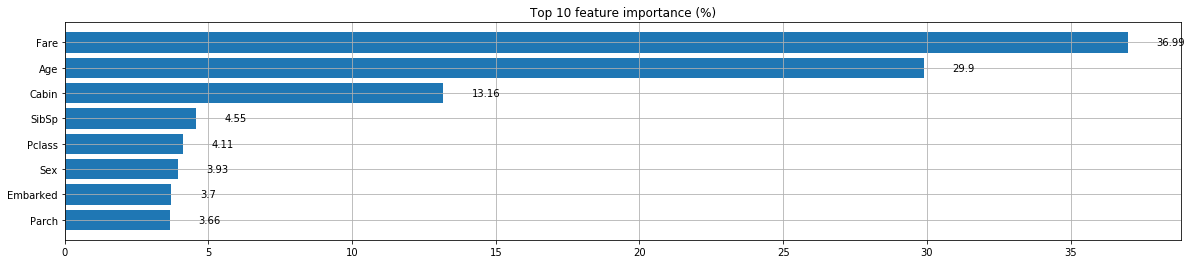


> Feature importances dumped into directory : save

predicting ...
CPU time: 0.0451507568359375 seconds

> Overview on predictions : 

        0.0       1.0  Survived_predicted
0  0.943844  0.056156                   0
1  0.919160  0.080840                   0
2  0.805279  0.194721                   0
3  0.804562  0.195438                   0
4  0.652513  0.347487                   0
5  0.686406  0.313594                   0
6  0.617232  0.382768                   0
7  0.906322  0.093678                   0
8  0.105139  0.894861                   1
9  0.966687  0.033313                   0

dumping predictions into directory : save ...


In [16]:
prd = Predictor()
prd.fit_predict(params, df)

### Formatting for submission

In [17]:
submit = pd.read_csv("/content/gender_submission.csv",sep=',')
preds = pd.read_csv("save/"+target_name+"_predictions.csv")

submit[target_name] =  preds[target_name+"_predicted"].values

submit.to_csv("titanic_3.csv", index=False)

change the params for best accuracy!